In [1]:
import glob
import pandas as pd
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, random_split

import sys
sys.path.append('Affective-AI-Music-Improviser')

from model import TCN
from tokenization import PrettyMidiTokenizer, BCI_TOKENS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width',1000)


DIRECTORY_PATH = ''

# MODEL PARAMETERS
EPOCHS = 500 # 500
LEARNING_RATE = 1 # 4
BATCH_SIZE = 4 # 16
TRAIN_MODEL = True
FEEDBACK = False
EMPHASIZE_EEG = True
EARLY_STOP = True


False


In [2]:
'''
Assumptions:
Sequences described as input_#.mid and output_#.mid in the corresponding folders
'''
DATASET_PATH = os.path.join(DIRECTORY_PATH, 'dataset')

print(DATASET_PATH)

input_filenames = sorted(glob.glob(os.path.join(DATASET_PATH, 'input/*.mid')))
print('Number of input files:', len(input_filenames))

output_filenames = sorted(glob.glob(os.path.join(DATASET_PATH, 'output/*.mid')))
print('Number of output files:', len(output_filenames), '\n')


INPUT_TOK = PrettyMidiTokenizer()
OUTPUT_TOK = PrettyMidiTokenizer()

for i, (in_file, out_file) in enumerate(zip(input_filenames, output_filenames)):

    in_file_name = os.path.basename(in_file)
    out_file_name = os.path.basename(out_file)
    print(f'{i + 1}: {in_file_name} -> {out_file_name}')

    if 'RELAX' in in_file_name:
        emotion_token = BCI_TOKENS[0]
    elif 'EXCITED' in in_file_name:
        emotion_token = BCI_TOKENS[1]
    else:
        raise Exception('Emotion not found in file name. Please add the emotion to the file name.')

    in_seq, in_df = INPUT_TOK.midi_to_tokens(in_file, update_vocab=True, update_sequences=True, emotion_token = emotion_token)
    out_seq, out_df = OUTPUT_TOK.midi_to_tokens(out_file, update_vocab=True, update_sequences=True)

    print(f'Input sequence length: {len(in_seq)}')
    print(f'Emotion token: {emotion_token}\n')

print(f'\nNumber of input sequences: {len(INPUT_TOK.sequences)}')
print(f'Input sequence length: {len(INPUT_TOK.sequences[0])}')
print(f'Input vocabulars size: {len(INPUT_TOK.VOCAB)}')
print(f'\nNumber of output sequences: {len(OUTPUT_TOK.sequences)}')
print(f'Output sequence length: {len(OUTPUT_TOK.sequences[0])}')
print(f'Output vocabulars size: {len(OUTPUT_TOK.VOCAB)}')

print('\nInput vocab:', INPUT_TOK.VOCAB.word2idx)
print('Output vocab:', OUTPUT_TOK.VOCAB.word2idx)


dataset
Number of input files: 6
Number of output files: 6 

1: 0_Drum_HardRock_EXCITED.mid -> 0_Bass_HardRock_EXCITED.mid
Input sequence length: 26
Emotion token: C

2: 1_Drum_HardRock_EXCITED.mid -> 1_Bass_HardRock_EXCITED.mid
Input sequence length: 32
Emotion token: C

3: 2_Drum_Blues_EXCITED.mid -> 2_Bass_Blues_EXCITED.mid
Input sequence length: 20
Emotion token: C

4: 3_Drum_Blues_EXCITED.mid -> 3_Bass_Blues_EXCITED.mid
Input sequence length: 20
Emotion token: C

5: 4_Drum_PopRock_RELAX.mid -> 4_Bass_PopRock_RELAX.mid
Input sequence length: 35
Emotion token: R

6: 5_Drum_PopRock_RELAX.mid -> 5_Bass_PopRock_RELAX.mid
Input sequence length: 23
Emotion token: R


Number of input sequences: 156
Input sequence length: 192
Input vocabulars size: 98

Number of output sequences: 156
Output sequence length: 192
Output vocabulars size: 87

Input vocab: {'O': 0, 'R': 1, 'C': 2, '36fS': 3, '36f': 4, '36f_42pS': 5, '38fS': 6, '38f': 7, '38f_42pS': 8, '36fS_42fS': 9, '38fS_42fS': 10, '38f_42f':

In [ ]:
# Perform data augmentation
input_shifts = [-3, -2, -1, 1, 2, 3]
output_shifts = list(np.zeros(len(input_shifts)))

INPUT_TOK.data_augmentation_shift(input_shifts)
OUTPUT_TOK.data_augmentation_shift(output_shifts)

print(f'\nNumber of input sequences after data augmentation: {len(INPUT_TOK.sequences)}')
print(f'Number of output sequences after data augmentation: {len(OUTPUT_TOK.sequences)}')


Number of input sequences after data augmentation: 1197
Number of output sequences after data augmentation: 1197


In [ ]:
# Create the dataset
dataset = TensorDataset(torch.LongTensor(INPUT_TOK.sequences).to(device),
                        torch.LongTensor(OUTPUT_TOK.sequences).to(device))

# Split the dataset into training, evaluation and test sets
train_set, eval_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

def initialize_dataset():

  # Create the dataloaders
  train_sampler = RandomSampler(train_set)
  train_dataloader = DataLoader(train_set, sampler=train_sampler, batch_size=BATCH_SIZE)

  eval_sampler = RandomSampler(eval_set)
  eval_dataloader = DataLoader(eval_set, sampler=eval_sampler, batch_size=BATCH_SIZE)

  test_sampler = RandomSampler(test_set)
  test_dataloader = DataLoader(test_set, sampler=test_sampler, batch_size=BATCH_SIZE)

  return train_dataloader, eval_dataloader, test_dataloader

train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()

print(f'Train set size: {len(train_set)}')
print(f'Evaluation set size: {len(eval_set)}')
print(f'Test set size: {len(test_set)}')



<ipython-input-6-b3faa26fa5c3>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  dataset = TensorDataset(torch.LongTensor(INPUT_TOK.sequences).to(device),


Train set size: 958
Evaluation set size: 120
Test set size: 119


In [ ]:
# Set the hyperparameters
SEED = 1111
torch.manual_seed(SEED)

'''
IMPORTANT:
to cover all the sequence of tokens k * d must be >= hidden units (see the paper)
k = kernel_size
d = dilation = 2 ^ (n_levels - 1)
'''

OUTPUT_SIZE = len(OUTPUT_TOK.VOCAB)

if FEEDBACK:
    INPUT_SIZE = len(INPUT_TOK.VOCAB) + OUTPUT_SIZE
    LEVELS = 8
    HIDDEN_UNITS = INPUT_TOK.SEQ_LENGTH * 2 # 192 * 2 = 384
else:
    INPUT_SIZE = len(INPUT_TOK.VOCAB)
    LEVELS = 7
    HIDDEN_UNITS = INPUT_TOK.SEQ_LENGTH # 192


EMBEDDING_SIZE = 20 # size of word embeddings -> Embedding() is used to encode input token into [192, 20] real value vectors (see model.py)
NUM_CHANNELS = [HIDDEN_UNITS] * (LEVELS - 1) + [EMBEDDING_SIZE] # [192, 192, 192, 192, 192, 192, 20]
GRADIENT_CLIP = 0.35


# balance the loss function by assigning a weight to each token related to its frequency
LOSS_WEIGTHS = torch.ones([OUTPUT_SIZE], dtype=torch.float, device = device)
OUTPUT_TOK.VOCAB.compute_weights()
for i, weigth in enumerate(OUTPUT_TOK.VOCAB.weights):
    LOSS_WEIGTHS[i] = 1 - weigth
    # print(f'{OUTPUT_TOK.VOCAB.idx2word[i]}: {LOSS_WEIGTHS[i]}')


def initialize_model():
  # create the model
  model = TCN(input_size = INPUT_SIZE,
              embedding_size = EMBEDDING_SIZE,
              output_size = OUTPUT_SIZE,
              num_channels = NUM_CHANNELS,
              emphasize_eeg = EMPHASIZE_EEG,
              dropout = 0.45,
              emb_dropout = 0.25,
              kernel_size = 3,
              tied_weights = False) # tie encoder and decoder weights (legare)

  model.to(device)

  # May use adaptive softmax to speed up training
  criterion = nn.CrossEntropyLoss(weight = LOSS_WEIGTHS)
  optimizer = getattr(optim, 'SGD')(model.parameters(), lr=LEARNING_RATE)

  return model, criterion, optimizer

model, criterion, optimizer = initialize_model()

print(f'\nModel created: {model}')
print(model.encoder.weight[0])


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")



Model created: TCN(
  (encoder): Embedding(92, 20, padding_idx=0)
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(20, 192, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.45, inplace=False)
        (conv2): Conv1d(192, 192, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.45, inplace=False)
        (net): Sequential(
          (0): Conv1d(20, 192, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.45, inplace=False)
          (4): Conv1d(192, 192, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.45, inplace=False)
        )
        (downsample): Conv1d(20, 192, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): Temp

In [ ]:
def save_parameters():

    # plot the losses over the epochs
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='train')
    plt.plot(eval_losses, label='eval')
    plt.legend()
    plt.savefig(os.path.join(RESULTS_PATH, 'losses.png'))
    plt.clf()

    # save the vocabularies
    INPUT_TOK.VOCAB.save(os.path.join(RESULTS_PATH, 'input_vocab.txt'))
    OUTPUT_TOK.VOCAB.save(os.path.join(RESULTS_PATH, 'output_vocab.txt'))

     # save the model hyperparameters in a file txt
    with open(os.path.join(RESULTS_PATH, 'model_hyperparameters.txt'), 'w') as f:

        f.write(f'DATE: {time.strftime("%Y%m%d-%H%M%S")}\n\n')

        f.write(f'-----------------DATASET------------------\n')
        f.write(f'DATASET_PATH: {DATASET_PATH}\n')
        f.write(f'TRAIN_SET_SIZE: {len(train_set)}\n')
        f.write(f'EVAL_SET_SIZE: {len(eval_set)}\n')
        f.write(f'TEST_SET_SIZE: {len(test_set)}\n\n')


        f.write(f'----------OPTIMIZATION PARAMETERS----------\n')
        f.write(f'GRADIENT_CLIP: {GRADIENT_CLIP}\n')
        f.write(f'FEEDBACK: {FEEDBACK}\n')
        f.write(f'EARLY STOPPING: {EARLY_STOP}\n')
        f.write(f'EMPHASIZE_EEG: {EMPHASIZE_EEG}\n')
        f.write(f'LEARNING_RATE: {LEARNING_RATE}\n')
        f.write(f'BATCH_SIZE: {BATCH_SIZE}\n')
        f.write(f'EPOCHS: {EPOCHS}\n\n')


        f.write(f'------------MODEL PARAMETERS--------------\n')
        f.write(f'SEED: {SEED}\n')
        f.write(f'INPUT_SIZE: {INPUT_SIZE}\n')
        f.write(f'EMBEDDING_SIZE: {EMBEDDING_SIZE}\n')
        f.write(f'LEVELS: {LEVELS}\n')
        f.write(f'HIDDEN_UNITS: {HIDDEN_UNITS}\n')
        f.write(f'NUM_CHANNELS: {NUM_CHANNELS}\n')
        f.write(f'OUTPUT_SIZE: {OUTPUT_SIZE}\n')
        f.write(f'LOSS_WEIGTHS: {LOSS_WEIGTHS}\n\n')



        f.write(f'-------------------RESULTS----------------\n')
        f.write(f'TRAIN_LOSSES: {best_train_loss}\n')
        f.write(f'BEST_EVAL_LOSS: {best_eval_loss}\n')
        f.write(f'TEST_LOSS: {test_loss}\n')
        f.write(f'BEST_MODEL_EPOCH: {best_model_epoch}\n')

In [ ]:
BAR_LENGTH = INPUT_TOK.BAR_LENGTH

def epoch_step(dataloader, mode):

    if FEEDBACK:
        prev_output = torch.zeros([BATCH_SIZE, INPUT_TOK.SEQ_LENGTH], dtype=torch.long, device=device)

    if mode == 'train':
        model.train()
    else:
        model.eval() # disable dropout

    total_loss = 0

    # iterate over the training data
    for batch_idx, (data, targets) in enumerate(dataloader):

        batch_idx += 1

        # mask the last bar of the input data
        batch_size = data.size(0)
        data_masked = torch.cat((data[:, :BAR_LENGTH*3], torch.ones([batch_size, BAR_LENGTH], dtype=torch.long, device = device)), dim = 1)

        if FEEDBACK:
            input = torch.cat((data_masked, prev_output[:batch_size, :]), dim = 1)
        else:
            input = data_masked

        # reset model gradients to zero
        optimizer.zero_grad()

        # make the prediction
        output = model(input)[:, :INPUT_TOK.SEQ_LENGTH]
        prev_output = torch.argmax(output, 2)# batch, seq_len (hidden units), vocab_size

        # flatten the output sequence
        # NB: the size -1 is inferred from other dimensions
        # NB: contiguous() is used to make sure the tensor is stored in a contiguous chunk of memory, necessary for view() to work

        final_target = targets.contiguous().view(-1)
        final_output = output.contiguous().view(-1, OUTPUT_SIZE)

        # calculate the loss
        loss = criterion(final_output, final_target)

        if mode == 'train':
            # calculate the gradients
            loss.backward()

            # clip the gradients to avoid exploding gradients
            if GRADIENT_CLIP > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)

            # update the weights
            optimizer.step()

        total_loss += loss.data.item()

    return total_loss / len(dataloader)


In [ ]:
def train():

    global RESULTS_PATH, MODEL_PATH
    global best_eval_loss, best_train_loss, best_model_epoch, train_losses, eval_losses

    RESULTS_PATH = os.path.join('content/results', time.strftime("%Y%m%d_%H%M%S"))
    if not os.path.exists(RESULTS_PATH):
        os.makedirs(RESULTS_PATH)

    MODEL_PATH = os.path.join(RESULTS_PATH, 'model_state_dict.pth')

    best_eval_loss = 1e8
    best_train_loss = 1e8
    best_model_epoch = 0
    eval_losses = []
    train_losses = []
    lr = LEARNING_RATE

    for epoch in range(1, EPOCHS+1):

        start_time = time.time()

        train_loss = epoch_step(train_dataloader, 'train')

        eval_loss = epoch_step(eval_dataloader, 'eval')

        # Save the model if the validation loss is the best we've seen so far.
        if eval_loss < best_eval_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_eval_loss = eval_loss
            best_model_epoch = epoch

        if train_loss < best_train_loss:
            best_train_loss = train_loss

        # # Anneal the learning rate if the validation loss plateaus
        # if epoch > 5 and eval_loss >= max(eval_losses[-5:]):
        #     lr = lr / 2.
        #     if lr < 0.1:
        #         lr = 2
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr


        eval_losses.append(eval_loss)
        train_losses.append(train_loss)

        # Early stopping
        if EARLY_STOP:
          if epoch > 15:
              if min(eval_losses[-15:]) > best_eval_loss:
                  break

        # print the loss and the progress
        elapsed = time.time() - start_time
        print('| epoch {:3d}/{:3d} | lr {:02.5f} | ms/epoch {:5.5f} | train_loss {:5.2f} | eval_loss {:5.2f}' \
                .format(epoch, EPOCHS, lr, elapsed * 1000, train_loss, eval_loss))


    print('\n\n TRAINING FINISHED:\n\n\tBest Loss: {:5.2f}\tBest Model saved at epoch: {:3d} \n\n' \
            .format(best_eval_loss, best_model_epoch))


    # test the model
    global test_loss
    test_loss = epoch_step(test_dataloader, 'eval')
    print(f'\n\nTEST LOSS: {test_loss}')

    save_parameters()

    ZIP_NAME = RESULTS_PATH.split('/')[-1]
    ZIP_NAME = f'{ZIP_NAME}.zip'
    print(ZIP_NAME)

    !zip -r $ZIP_NAME $RESULTS_PATH
    from google.colab import files
    files.download(f"/content/{ZIP_NAME}")



/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.r

| epoch   1/500 | lr 1.00000 | ms/epoch 6040.54856 | train_loss  3.48 | eval_loss  3.39
| epoch   2/500 | lr 1.00000 | ms/epoch 2973.57893 | train_loss  3.33 | eval_loss  3.39
| epoch   3/500 | lr 1.00000 | ms/epoch 3168.12968 | train_loss  3.23 | eval_loss  3.26
| epoch   4/500 | lr 1.00000 | ms/epoch 2963.20224 | train_loss  3.14 | eval_loss  3.04
| epoch   5/500 | lr 1.00000 | ms/epoch 3739.17174 | train_loss  3.02 | eval_loss  2.89
| epoch   6/500 | lr 1.00000 | ms/epoch 2909.49559 | train_loss  2.90 | eval_loss  2.90
| epoch   7/500 | lr 1.00000 | ms/epoch 3057.72161 | train_loss  2.82 | eval_loss  2.67
| epoch   8/500 | lr 1.00000 | ms/epoch 3007.11894 | train_loss  2.73 | eval_loss  2.65
| epoch   9/500 | lr 1.00000 | ms/epoch 3717.89861 | train_loss  2.65 | eval_loss  2.57
| epoch  10/500 | lr 1.00000 | ms/epoch 2967.62156 | train_loss  2.58 | eval_loss  2.55
| epoch  11/500 | lr 1.00000 | ms/epoch 2916.33868 | train_loss  2.52 | eval_loss  2.39
| epoch  12/500 | lr 1.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 2.00000 | ms/epoch 2926.82076 | train_loss  3.47 | eval_loss  3.40
| epoch   2/500 | lr 2.00000 | ms/epoch 2936.76233 | train_loss  3.29 | eval_loss  3.15
| epoch   3/500 | lr 2.00000 | ms/epoch 3100.82316 | train_loss  3.11 | eval_loss  3.11
| epoch   4/500 | lr 2.00000 | ms/epoch 3639.49347 | train_loss  2.95 | eval_loss  2.83
| epoch   5/500 | lr 2.00000 | ms/epoch 3026.93701 | train_loss  2.83 | eval_loss  2.62
| epoch   6/500 | lr 2.00000 | ms/epoch 3002.85244 | train_loss  2.73 | eval_loss  2.54
| epoch   7/500 | lr 2.00000 | ms/epoch 3058.55536 | train_loss  2.64 | eval_loss  2.49
| epoch   8/500 | lr 2.00000 | ms/epoch 3712.67438 | train_loss  2.55 | eval_loss  2.43
| epoch   9/500 | lr 2.00000 | ms/epoch 2939.58211 | train_loss  2.46 | eval_loss  2.32
| epoch  10/500 | lr 2.00000 | ms/epoch 2992.75517 | train_loss  2.39 | eval_loss  2.23
| epoch  11/500 | lr 2.00000 | ms/epoch 2986.07183 | train_loss  2.33 | eval_loss  2.24
| epoch  12/500 | lr 2.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 4.00000 | ms/epoch 2910.04133 | train_loss  3.48 | eval_loss  3.43
| epoch   2/500 | lr 4.00000 | ms/epoch 2892.71331 | train_loss  3.42 | eval_loss  3.39
| epoch   3/500 | lr 4.00000 | ms/epoch 3509.36937 | train_loss  3.41 | eval_loss  3.38
| epoch   4/500 | lr 4.00000 | ms/epoch 3033.83660 | train_loss  3.41 | eval_loss  3.40
| epoch   5/500 | lr 4.00000 | ms/epoch 2991.72044 | train_loss  3.40 | eval_loss  3.38
| epoch   6/500 | lr 4.00000 | ms/epoch 2953.25398 | train_loss  3.41 | eval_loss  3.38
| epoch   7/500 | lr 4.00000 | ms/epoch 3490.42797 | train_loss  3.41 | eval_loss  3.38
| epoch   8/500 | lr 4.00000 | ms/epoch 2843.21356 | train_loss  3.40 | eval_loss  3.40
| epoch   9/500 | lr 4.00000 | ms/epoch 2918.95223 | train_loss  3.40 | eval_loss  3.39
| epoch  10/500 | lr 4.00000 | ms/epoch 2879.08483 | train_loss  3.41 | eval_loss  3.40
| epoch  11/500 | lr 4.00000 | ms/epoch 3478.36328 | train_loss  3.41 | eval_loss  3.38
| epoch  12/500 | lr 4.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 1.00000 | ms/epoch 1510.48803 | train_loss  3.52 | eval_loss  3.39
| epoch   2/500 | lr 1.00000 | ms/epoch 1447.40462 | train_loss  3.40 | eval_loss  3.38
| epoch   3/500 | lr 1.00000 | ms/epoch 1971.33708 | train_loss  3.32 | eval_loss  3.24
| epoch   4/500 | lr 1.00000 | ms/epoch 1635.07295 | train_loss  3.25 | eval_loss  3.13
| epoch   5/500 | lr 1.00000 | ms/epoch 1518.12887 | train_loss  3.19 | eval_loss  3.14
| epoch   6/500 | lr 1.00000 | ms/epoch 1428.22504 | train_loss  3.14 | eval_loss  3.09
| epoch   7/500 | lr 1.00000 | ms/epoch 1498.95287 | train_loss  3.08 | eval_loss  2.99
| epoch   8/500 | lr 1.00000 | ms/epoch 1536.78703 | train_loss  3.01 | eval_loss  2.93
| epoch   9/500 | lr 1.00000 | ms/epoch 1470.90554 | train_loss  2.92 | eval_loss  2.86
| epoch  10/500 | lr 1.00000 | ms/epoch 1614.08091 | train_loss  2.87 | eval_loss  2.77
| epoch  11/500 | lr 1.00000 | ms/epoch 1991.94050 | train_loss  2.80 | eval_loss  2.75
| epoch  12/500 | lr 1.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 1.00000 | ms/epoch 1289.23583 | train_loss  3.59 | eval_loss  3.42
| epoch   2/500 | lr 1.00000 | ms/epoch 1068.91394 | train_loss  3.43 | eval_loss  3.40
| epoch   3/500 | lr 1.00000 | ms/epoch 968.03808 | train_loss  3.40 | eval_loss  3.34
| epoch   4/500 | lr 1.00000 | ms/epoch 1000.48995 | train_loss  3.36 | eval_loss  3.34
| epoch   5/500 | lr 1.00000 | ms/epoch 996.98997 | train_loss  3.29 | eval_loss  3.21
| epoch   6/500 | lr 1.00000 | ms/epoch 999.41802 | train_loss  3.25 | eval_loss  3.27
| epoch   7/500 | lr 1.00000 | ms/epoch 1006.32071 | train_loss  3.21 | eval_loss  3.14
| epoch   8/500 | lr 1.00000 | ms/epoch 991.75429 | train_loss  3.18 | eval_loss  3.09
| epoch   9/500 | lr 1.00000 | ms/epoch 971.52162 | train_loss  3.15 | eval_loss  3.18
| epoch  10/500 | lr 1.00000 | ms/epoch 988.56258 | train_loss  3.12 | eval_loss  3.06
| epoch  11/500 | lr 1.00000 | ms/epoch 998.96622 | train_loss  3.09 | eval_loss  3.00
| epoch  12/500 | lr 1.00000 | ms/epoch

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 1.00000 | ms/epoch 936.61904 | train_loss  3.72 | eval_loss  3.42
| epoch   2/500 | lr 1.00000 | ms/epoch 827.20590 | train_loss  3.47 | eval_loss  3.38
| epoch   3/500 | lr 1.00000 | ms/epoch 815.46307 | train_loss  3.44 | eval_loss  3.39
| epoch   4/500 | lr 1.00000 | ms/epoch 835.22081 | train_loss  3.42 | eval_loss  3.37
| epoch   5/500 | lr 1.00000 | ms/epoch 832.43442 | train_loss  3.40 | eval_loss  3.36
| epoch   6/500 | lr 1.00000 | ms/epoch 855.28851 | train_loss  3.38 | eval_loss  3.34
| epoch   7/500 | lr 1.00000 | ms/epoch 838.43088 | train_loss  3.35 | eval_loss  3.36
| epoch   8/500 | lr 1.00000 | ms/epoch 855.39007 | train_loss  3.34 | eval_loss  3.25
| epoch   9/500 | lr 1.00000 | ms/epoch 815.59324 | train_loss  3.30 | eval_loss  3.30
| epoch  10/500 | lr 1.00000 | ms/epoch 836.45606 | train_loss  3.28 | eval_loss  3.19
| epoch  11/500 | lr 1.00000 | ms/epoch 813.90238 | train_loss  3.25 | eval_loss  3.28
| epoch  12/500 | lr 1.00000 | ms/epoch 830

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 1.00000 | ms/epoch 1486.79280 | train_loss  3.73 | eval_loss  3.44
| epoch   2/500 | lr 1.00000 | ms/epoch 1446.88106 | train_loss  3.47 | eval_loss  3.46
| epoch   3/500 | lr 1.00000 | ms/epoch 1452.16060 | train_loss  3.44 | eval_loss  3.45
| epoch   4/500 | lr 1.00000 | ms/epoch 1463.52792 | train_loss  3.42 | eval_loss  3.37
| epoch   5/500 | lr 1.00000 | ms/epoch 1455.35827 | train_loss  3.40 | eval_loss  3.38
| epoch   6/500 | lr 1.00000 | ms/epoch 1462.75926 | train_loss  3.37 | eval_loss  3.42
| epoch   7/500 | lr 1.00000 | ms/epoch 1469.61927 | train_loss  3.37 | eval_loss  3.36
| epoch   8/500 | lr 1.00000 | ms/epoch 1459.42020 | train_loss  3.33 | eval_loss  3.25
| epoch   9/500 | lr 1.00000 | ms/epoch 1444.99159 | train_loss  3.30 | eval_loss  3.28
| epoch  10/500 | lr 1.00000 | ms/epoch 1461.47037 | train_loss  3.27 | eval_loss  3.20
| epoch  11/500 | lr 1.00000 | ms/epoch 1457.09610 | train_loss  3.24 | eval_loss  3.15
| epoch  12/500 | lr 1.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 2.00000 | ms/epoch 1454.00119 | train_loss  3.67 | eval_loss  3.43
| epoch   2/500 | lr 2.00000 | ms/epoch 1467.36979 | train_loss  3.46 | eval_loss  3.41
| epoch   3/500 | lr 2.00000 | ms/epoch 1448.94695 | train_loss  3.41 | eval_loss  3.44
| epoch   4/500 | lr 2.00000 | ms/epoch 1467.74626 | train_loss  3.40 | eval_loss  3.41
| epoch   5/500 | lr 2.00000 | ms/epoch 1457.65257 | train_loss  3.38 | eval_loss  3.30
| epoch   6/500 | lr 2.00000 | ms/epoch 1455.32084 | train_loss  3.36 | eval_loss  3.25
| epoch   7/500 | lr 2.00000 | ms/epoch 1433.22635 | train_loss  3.30 | eval_loss  3.35
| epoch   8/500 | lr 2.00000 | ms/epoch 1438.66420 | train_loss  3.29 | eval_loss  3.25
| epoch   9/500 | lr 2.00000 | ms/epoch 1460.69860 | train_loss  3.27 | eval_loss  3.23
| epoch  10/500 | lr 2.00000 | ms/epoch 1445.23335 | train_loss  3.23 | eval_loss  3.13
| epoch  11/500 | lr 2.00000 | ms/epoch 1445.62268 | train_loss  3.19 | eval_loss  3.16
| epoch  12/500 | lr 2.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 4.00000 | ms/epoch 1440.50264 | train_loss  3.66 | eval_loss  3.40
| epoch   2/500 | lr 4.00000 | ms/epoch 1442.88898 | train_loss  3.44 | eval_loss  3.38
| epoch   3/500 | lr 4.00000 | ms/epoch 1436.61523 | train_loss  3.41 | eval_loss  3.43
| epoch   4/500 | lr 4.00000 | ms/epoch 1461.12633 | train_loss  3.40 | eval_loss  3.36
| epoch   5/500 | lr 4.00000 | ms/epoch 1442.90447 | train_loss  3.44 | eval_loss  3.30
| epoch   6/500 | lr 4.00000 | ms/epoch 1441.09297 | train_loss  3.33 | eval_loss  3.23
| epoch   7/500 | lr 4.00000 | ms/epoch 1430.22108 | train_loss  3.33 | eval_loss  3.25
| epoch   8/500 | lr 4.00000 | ms/epoch 1445.08481 | train_loss  3.23 | eval_loss  3.14
| epoch   9/500 | lr 4.00000 | ms/epoch 1440.19842 | train_loss  3.18 | eval_loss  3.13
| epoch  10/500 | lr 4.00000 | ms/epoch 1433.97665 | train_loss  3.11 | eval_loss  3.07
| epoch  11/500 | lr 4.00000 | ms/epoch 1451.99990 | train_loss  3.07 | eval_loss  2.97
| epoch  12/500 | lr 4.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 1.00000 | ms/epoch 1970.89815 | train_loss  3.52 | eval_loss  3.44
| epoch   2/500 | lr 1.00000 | ms/epoch 1913.43546 | train_loss  3.41 | eval_loss  3.39
| epoch   3/500 | lr 1.00000 | ms/epoch 1913.82265 | train_loss  3.33 | eval_loss  3.20
| epoch   4/500 | lr 1.00000 | ms/epoch 1871.80519 | train_loss  3.25 | eval_loss  3.19
| epoch   5/500 | lr 1.00000 | ms/epoch 1988.28149 | train_loss  3.19 | eval_loss  3.07
| epoch   6/500 | lr 1.00000 | ms/epoch 2141.56771 | train_loss  3.13 | eval_loss  3.19
| epoch   7/500 | lr 1.00000 | ms/epoch 1888.66591 | train_loss  3.07 | eval_loss  2.98
| epoch   8/500 | lr 1.00000 | ms/epoch 1894.96493 | train_loss  2.99 | eval_loss  2.91
| epoch   9/500 | lr 1.00000 | ms/epoch 1907.41205 | train_loss  2.92 | eval_loss  2.80
| epoch  10/500 | lr 1.00000 | ms/epoch 1866.97125 | train_loss  2.86 | eval_loss  2.86
| epoch  11/500 | lr 1.00000 | ms/epoch 1904.41084 | train_loss  2.81 | eval_loss  2.72
| epoch  12/500 | lr 1.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 1.00000 | ms/epoch 1596.26508 | train_loss  3.59 | eval_loss  3.39
| epoch   2/500 | lr 1.00000 | ms/epoch 1555.92132 | train_loss  3.43 | eval_loss  3.42
| epoch   3/500 | lr 1.00000 | ms/epoch 1581.73323 | train_loss  3.41 | eval_loss  3.38
| epoch   4/500 | lr 1.00000 | ms/epoch 1571.39277 | train_loss  3.37 | eval_loss  3.32
| epoch   5/500 | lr 1.00000 | ms/epoch 1568.22252 | train_loss  3.31 | eval_loss  3.22
| epoch   6/500 | lr 1.00000 | ms/epoch 1634.27687 | train_loss  3.26 | eval_loss  3.14
| epoch   7/500 | lr 1.00000 | ms/epoch 1592.02766 | train_loss  3.22 | eval_loss  3.13
| epoch   8/500 | lr 1.00000 | ms/epoch 1572.15333 | train_loss  3.18 | eval_loss  3.12
| epoch   9/500 | lr 1.00000 | ms/epoch 1557.57046 | train_loss  3.17 | eval_loss  3.19
| epoch  10/500 | lr 1.00000 | ms/epoch 1566.95962 | train_loss  3.14 | eval_loss  3.02
| epoch  11/500 | lr 1.00000 | ms/epoch 1546.91529 | train_loss  3.11 | eval_loss  3.03
| epoch  12/500 | lr 1.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

| epoch   1/500 | lr 1.00000 | ms/epoch 1453.42779 | train_loss  3.72 | eval_loss  3.48
| epoch   2/500 | lr 1.00000 | ms/epoch 1461.17282 | train_loss  3.47 | eval_loss  3.45
| epoch   3/500 | lr 1.00000 | ms/epoch 1459.85413 | train_loss  3.44 | eval_loss  3.41
| epoch   4/500 | lr 1.00000 | ms/epoch 1457.41343 | train_loss  3.41 | eval_loss  3.40
| epoch   5/500 | lr 1.00000 | ms/epoch 1457.49116 | train_loss  3.40 | eval_loss  3.41
| epoch   6/500 | lr 1.00000 | ms/epoch 1469.35058 | train_loss  3.37 | eval_loss  3.37
| epoch   7/500 | lr 1.00000 | ms/epoch 1461.93457 | train_loss  3.35 | eval_loss  3.31
| epoch   8/500 | lr 1.00000 | ms/epoch 1456.18367 | train_loss  3.32 | eval_loss  3.24
| epoch   9/500 | lr 1.00000 | ms/epoch 1457.24797 | train_loss  3.28 | eval_loss  3.20
| epoch  10/500 | lr 1.00000 | ms/epoch 1443.62974 | train_loss  3.26 | eval_loss  3.24
| epoch  11/500 | lr 1.00000 | ms/epoch 1457.68666 | train_loss  3.23 | eval_loss  3.15
| epoch  12/500 | lr 1.00000 | m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

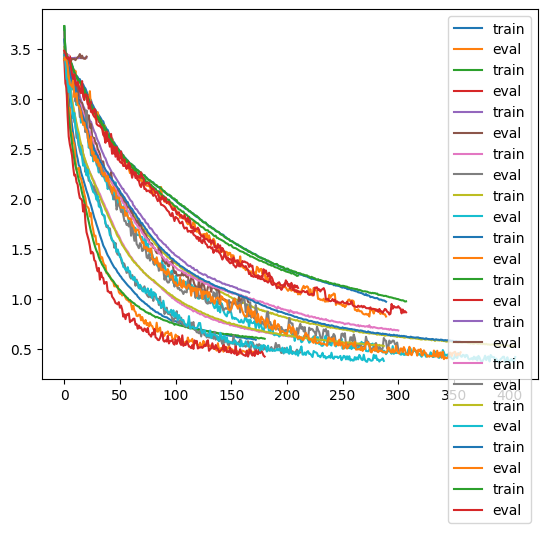

In [ ]:
# MODEL PARAMETERS
EPOCHS = 500 # 500
LEARNING_RATE = 1 # 4
BATCH_SIZE = 4 # 16
TRAIN_MODEL = True
FEEDBACK = False
EMPHASIZE_EEG = True
EARLY_STOP = True


if TRAIN_MODEL:

  for i in range(2):

    if i == 0:
      FEEDBACK = False
    else:
      FEEDBACK = True

    BATCH_SIZE = 4
    LEARNING_RATE = 1.0
    model, criterion, optimizer = initialize_model()
    train()

    LEARNING_RATE = 2.0
    model, criterion, optimizer = initialize_model()
    train()

    LEARNING_RATE = 4.0
    model, criterion, optimizer = initialize_model()
    train()

    LEARNING_RATE = 1.0
    BATCH_SIZE = 8
    train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()
    model, criterion, optimizer = initialize_model()
    train()

    BATCH_SIZE = 16
    train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()
    model, criterion, optimizer = initialize_model()
    train()

    BATCH_SIZE = 32
    train_dataloader, eval_dataloader, test_dataloader = initialize_dataset()
    model, criterion, optimizer = initialize_model()
    train()